In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import os 
import pandas as pd 
import datetime 


## KITTY DATASET 
In this analysis of visual odometry I'm using kitty dataset that you can get at: https://www.cvlibs.net/datasets/kitti/eval_odometry.php. <br>
Kitty dataset contains data from stereo camera, 3D lidar, ground thruth poses from gps and calibration files for camera. For more info read kitty_readme.txt

### Obtain Ground truth poses
Poses are normally represented in a 3x4 transormation matrix T. First 3 colums are 3x3 rotation matrix and last column is 3x1 translation vector. <br>
In kitty dataset sequance of 4541 ground truth poses (first sequance from dataset) is stored as 4541x12 table. 12 columns come from flattening a 3x4 matrix to one row. <br> Transformation matrixies represent position of the left camera (stereo pair) with respest to the global coordinate frame. Global frame is coordinate frame of the first camera pose. 

In [2]:
# get gt poses in flattened version
ground_truth_poses = pd.read_csv('../KITTY_dataset/ground_truth_poses/00.txt', delimiter=' ', header=None)
print("poses shape ", ground_truth_poses.shape)
ground_truth_poses.head(5)


poses shape  (4541, 12)


,0,1,2,3,4,5,6,7,8,9,10,11
0,1.000000,9.043680e-12,2.326809e-11,5.551115e-17,9.043683e-12,1.000000,2.392370e-10,3.330669e-16,2.326810e-11,2.392370e-10,1.000000,-4.440892e-16
1,0.999998,5.272628e-04,-2.066935e-03,-4.690294e-02,-5.296506e-04,0.999999,-1.154865e-03,-2.839928e-02,2.066324e-03,1.155958e-03,0.999997,8.586941e-01
2,0.999991,1.048972e-03,-4.131348e-03,-9.374345e-02,-1.058514e-03,0.999997,-2.308104e-03,-5.676064e-02,4.128913e-03,2.312456e-03,0.999989,1.716275e+00
3,0.999980,1.566466e-03,-6.198571e-03,-1.406429e-01,-1.587952e-03,0.999993,-3.462706e-03,-8.515762e-02,6.193102e-03,3.472479e-03,0.999975,2.574964e+00
4,0.999964,2.078471e-03,-8.263498e-03,-1.874858e-01,-2.116664e-03,0.999987,-4.615826e-03,-1.135202e-01,8.253797e-03,4.633149e-03,0.999955,3.432648e+00


In [3]:
# unflatten transformation matrixies 
gt_poses = np.zeros((len(ground_truth_poses),3,4)) # transformation matrixies in 3x4 version
trajectory = []
for npose in range(len(ground_truth_poses)): 
    gt_poses[npose] = (np.array(ground_truth_poses.iloc[npose]).reshape((3,4)))
    #trajectory[npose] = gt_poses[npose].dot(origin)

print(gt_poses.shape)
print(gt_poses[0].round(2)) #first pose

(4541, 3, 4)
[[ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  1. -0.]]


In [4]:
# to calculate camera position relative to global frame we need to have camera frame/camera origin  
camera_origin = np.array([0,0,0,1]) # x,y,z,theta

#now we can calculate camera position in n frame  / position not pose !!
second_camera_pose = gt_poses[1].dot(camera_origin)
print(second_camera_pose.round(2))

[-0.05 -0.03  0.86]


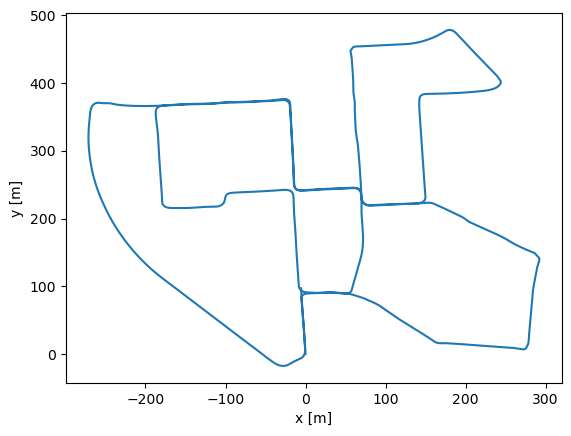

In [5]:
# plot ground truth poses
plt.plot(gt_poses[:,:,3][:,0], gt_poses[:,:,3][:,2])
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.show()

# you have to remember that on plot labels x and y refer to how we normally understand movement
#in kitty dataset frame is set as camera frame, so z is forward/back, x is left/right, and y is up/down (down is positive)
# you can see it on camera pics later

(376, 1241, 3)


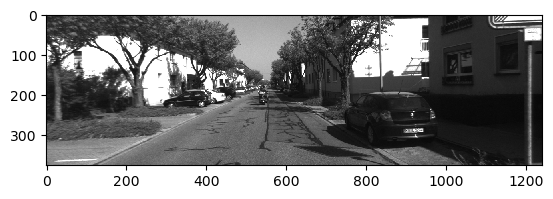

In [6]:
# check out camera images
test_img = cv.imread('../KITTY_dataset/sequences/00/image_0/000000.png') #image_0 is left camera and image_1 is right camera
print(test_img.shape)

%matplotlib inline 
plt.figure()
plt.imshow(test_img)

In [7]:
# read camera imgs, times and calibration data 
left_camera_imgs = os.listdir('../KITTY_dataset/sequences/00/image_0')
times = pd.read_csv('../KITTY_dataset/sequences/00/times.txt', header=None)

# Calibration data for the cameras: P0/P1 are the 3x4 projection matrices after rectification. Here P0 denotes the left and P1 denotes the
# right camera. Tr transforms a point from velodyne coordinates into the left rectified camera coordinate system. 

calib = pd.read_csv('../KITTY_dataset/sequences/00/calib.txt', delimiter=' ',header=None, index_col=0)
calib.head() # projection matricies 

,1,2,3,4,5,6,7,8,9,10,11,12
0,,,,,,,,,,,,
P0:,718.856000,0.000000,607.192800,0.000000,0.000000,718.856000,185.215700,0.000000,0.000000,0.000000,1.000000,0.000000
P1:,718.856000,0.000000,607.192800,-386.144800,0.000000,718.856000,185.215700,0.000000,0.000000,0.000000,1.000000,0.000000
P2:,718.856000,0.000000,607.192800,45.382250,0.000000,718.856000,185.215700,-0.113089,0.000000,0.000000,1.000000,0.003780
P3:,718.856000,0.000000,607.192800,-337.287700,0.000000,718.856000,185.215700,2.369057,0.000000,0.000000,1.000000,0.004915
Tr:,0.000428,-0.999967,-0.008084,-0.011985,-0.007211,0.008081,-0.999941,-0.054040,0.999974,0.000486,-0.007207,-0.292197
